In [1]:
from nnpdf import data, defaults, theory
from inference import pdfs
import numpy as np
import matplotlib.pyplot as plt
from eko import interpolation

In [2]:
# datasets I want to consider, random ordering
datasets_I_want = [
    #'HERACOMBNCEM',
    #'HERACOMBNCEP460', 
    #'HERACOMBNCEP575',
    #'HERACOMBNCEP820'
    #'HERACOMBNCEP920',
    #'HERACOMBCCEM',
    #'HERACOMBCCEP',
    #'HERACOMB_SIGMARED_B',
    'HERACOMB_SIGMARED_C'
]

# create a list with the correct prdering (which is the one which would be automatically used
# when building the FK table containing all the datasets)
datasets_list = []
for ds in data.data():
    ds_spec = {}
    if ds.setname in datasets_I_want:
        ds_spec['dataset'] = ds.setname
        datasets_list.append(ds_spec)

# load data and covmat for all the dataset
y = data.values(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)
cov = data.covmat(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)

In [3]:
datasets_list

[{'dataset': 'HERACOMB_SIGMARED_C'}]

In [4]:
y

array([0.31613 , 0.29041 , 0.24098 , 0.18134 , 0.14761 , 0.10103 ,
       0.31977 , 0.29049 , 0.25539 , 0.20163 , 0.163   , 0.11367 ,
       0.38846 , 0.37557 , 0.2807  , 0.21897 , 0.20149 , 0.15534 ,
       0.094026, 0.32542 , 0.32893 , 0.25762 , 0.1925  , 0.1596  ,
       0.094583, 0.37661 , 0.22743 , 0.21729 , 0.15186 , 0.070217,
       0.23889 , 0.17035 , 0.223   , 0.10646 , 0.2026  , 0.088456,
       0.060261])

In [5]:
fks = theory.theory(dataset_inputs=datasets_I_want)

In [6]:
#fks[0].elements[0].
fks[0].name

'HERACOMB_SIGMARED_C'

In [7]:
fks[0].elements[0].xgrid

array([2.97000000e-05, 4.12463026e-05, 5.72798543e-05, 7.95431074e-05,
       1.10453802e-04, 1.53365442e-04, 2.12927114e-04, 2.95579463e-04,
       4.10236358e-04, 5.69217889e-04, 7.89520017e-04, 1.09452838e-03,
       1.51630524e-03, 2.09859190e-03, 2.90065885e-03, 4.00207552e-03,
       5.50831824e-03, 7.55683146e-03, 1.03226526e-02, 1.40220111e-02,
       1.89115830e-02, 2.52807513e-02, 3.34349512e-02, 4.36704790e-02,
       5.62446538e-02, 7.13482653e-02, 8.90876333e-02, 1.09480539e-01,
       1.32465390e-01, 1.57919098e-01, 1.85677927e-01, 2.15556764e-01,
       2.47364362e-01, 2.80913969e-01, 3.16029873e-01, 3.52550818e-01,
       3.90331268e-01, 4.29241308e-01, 4.69165773e-01, 5.10002988e-01,
       5.51663367e-01, 5.94068017e-01, 6.37147427e-01, 6.80840268e-01,
       7.25092339e-01, 7.69855625e-01, 8.15087498e-01, 8.60750008e-01,
       9.06809285e-01, 9.53235016e-01])

In [8]:
#keep original grid (test for one dataset)
#newgrid=fks[0].elements[0].xgrid
#nxgrid=newgrid.size
#newgrid=np.concatenate([np.geomspace(1e-6, 0.1, 50), np.linspace(0.1, 1.0, 50)])
newgrid=np.geomspace(1e-6,1.,50)
nxgrid=newgrid.size

In [9]:
# look at the flavors of loaded fk tables and build the corresponding boolean mask
# assume some grid dimension for this

# possible flavors appearing in the FK tables for DIS data
flavs = [1,2,3,4,5,6,9,10,11]
#nxgrid = 50
mask_list=[]

for fk in fks:
    mask = [flav in fk.elements[0].flavors for flav in flavs for k in range(0,nxgrid)]
    mask_list.append(mask)

In [10]:
#mask_list

In [11]:
# now build the corresponding matrices
matrix_list = []
for m in mask_list:
    matrix = []
    for pos, i in enumerate(m):
        if i:
            tmp = np.zeros(len(flavs)*nxgrid)
            tmp[pos]=1.
            matrix.append(tmp)
    
    matrix_list.append(np.array(matrix))

In [12]:
#np.testing.assert_equal(matrix_list[0],np.identity(450))

In [13]:
# reshape to common grid
for fk in fks:
    fk.x_reshape(newgrid)

In [14]:
# reshape the fk tables to matrices 
fk_bare_list = []
for fk in fks:
    ndata, nbasis, nx = fk.elements[0].table.shape
    fk_bare_list.append(np.reshape(fk.elements[0].table,(ndata,nbasis*nx)))

In [15]:
# multiply fk for the matrix
reshaped_fk = []

for fk_bare, matrix in zip(fk_bare_list, matrix_list):
    reshaped_fk.append(fk_bare @ matrix)

In [16]:
fk_bare = np.concatenate([fk for fk in reshaped_fk], axis=0)
fk_bare.shape

(37, 450)

In [17]:
fk_grid=newgrid

In [18]:
# flavour basis pdfs evaluated on the FK xgrid
xg=pdfs.xf(21, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xu=pdfs.xf(2, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xd=pdfs.xf(1, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xs=pdfs.xf(3, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xc=pdfs.xf(4, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xubar=pdfs.xf(-2, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xdbar=pdfs.xf(-1, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xsbar=pdfs.xf(-3, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
xcbar=pdfs.xf(-4, "NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)

pdf_flavs = np.asarray([xg,xu,xd,xs,xc,xubar,xdbar,xsbar,xcbar])

In [19]:
pdf_flavs.shape

(9, 50)

In [20]:
pdf_evol=pdfs.rot_to_evolution@pdf_flavs

In [21]:
xSigma=pdf_evol[0,:]
xg=pdf_evol[1,:]
xV=pdf_evol[2,:]
xV3=pdf_evol[3,:]
xV8=pdf_evol[4,:] 
xV15=pdf_evol[5,:]
xT3=pdf_evol[6,:]
xT8=pdf_evol[7,:]
xT15=pdf_evol[8,:]

In [22]:
def plot_pdfs_cv(
    cvs,
    labels,
    grid
):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))  # 1 row, 2 columns
    for cv, label in zip(cvs, labels):

        ax1.plot(grid, cv, "-", label=label)
        ax2.plot(grid, cv, "-", label=label)

    ax1.set_xscale("linear")
    ax2.set_xscale("log")
    #ax1.set_ylim(ylinear)
    #ax2.set_ylim(ylog)

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

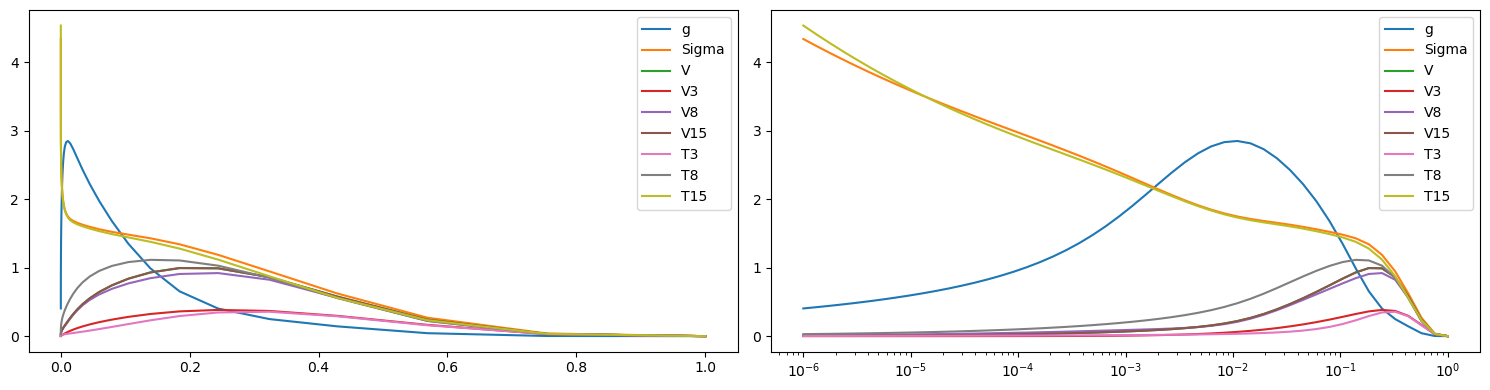

In [23]:
plot_pdfs_cv([xg,xSigma,xV,xV3,xV8,xV15,xT3,xT8,xT15],["g","Sigma","V","V3","V8","V15","T3","T8","T15"],fk_grid)

In [24]:
f=np.concatenate([xSigma,xg,xV,xV3,xV8,xV15,xT3,xT8,xT15])

In [25]:
f.shape

(450,)

In [26]:
fk_bare.shape

(37, 450)

In [27]:
yth=fk_bare@f

In [28]:
yth

array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [29]:
y

array([0.31613 , 0.29041 , 0.24098 , 0.18134 , 0.14761 , 0.10103 ,
       0.31977 , 0.29049 , 0.25539 , 0.20163 , 0.163   , 0.11367 ,
       0.38846 , 0.37557 , 0.2807  , 0.21897 , 0.20149 , 0.15534 ,
       0.094026, 0.32542 , 0.32893 , 0.25762 , 0.1925  , 0.1596  ,
       0.094583, 0.37661 , 0.22743 , 0.21729 , 0.15186 , 0.070217,
       0.23889 , 0.17035 , 0.223   , 0.10646 , 0.2026  , 0.088456,
       0.060261])

In [30]:
l, u = np.linalg.eigh(cov)  # usa np.linalg.eigh
cov_inv = u @ np.diag(1.0 / l) @ u.T
((y-yth)@cov_inv@(y-yth).T)/y.size

2.929897400924345

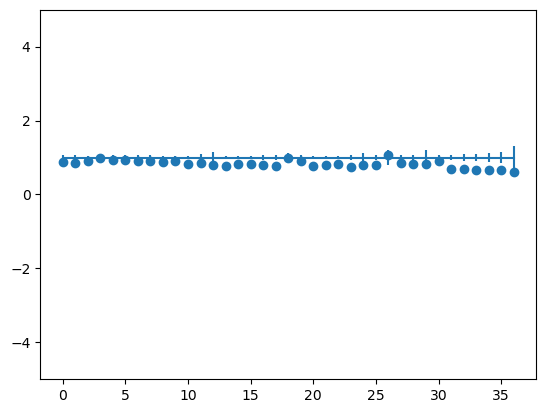

In [31]:
points=np.arange(y.size)
sigma=np.sqrt(np.diagonal(cov))/y
plt.errorbar(points,y/y,sigma)
plt.scatter(points,yth/y)
plt.ylim([-5,5])
plt.show()

In [32]:
# now repeat this but considering as basics object to convolute with the FK xS, xg, V, V3, V8, V15, T3, T8, T15

# look at the flavors of loaded fk tables and build the corresponding boolean mask
# assume some grid dimension for this

# possible flavors appearing in the FK tables for DIS data
flavs = [1,2,3,4,5,6,9,10,11]
#nxgrid = 50
mask_list=[]

for fk in fks:
    mask = [flav in fk.elements[0].flavors for flav in flavs for k in range(0,nxgrid)]
    mask_list.append(mask)
    
# now build the corresponding matrices
matrix_list = []
for m in mask_list:
    matrix = []
    for pos, i in enumerate(m):
        if i:
            tmp = np.zeros(len(flavs)*nxgrid)
            tmp[pos]=1.
            matrix.append(tmp)
    
    matrix_list.append(np.array(matrix))

# reshape to common grid
for fk in fks:
    fk.x_reshape(newgrid)
    
# reshape the fk tables to matrices 
fk_bare_list = []
for fk in fks:
    ndata, nbasis, nx = fk.elements[0].table.shape
    fk_bare_list.append(np.reshape(fk.elements[0].table,(ndata,nbasis*nx)))

# multiply fk for the matrix
reshaped_fk = []

for fk_bare, matrix in zip(fk_bare_list, matrix_list):
    reshaped_fk.append(fk_bare @ matrix)
    
fk_bare = np.concatenate([fk for fk in reshaped_fk], axis=0)
fk_bare.shape

(37, 450)

In [33]:
fk_bare @ f

array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [34]:
big_xgrid = np.concatenate([newgrid for i in range(2,9)])

In [35]:
big_xgrid.shape

(350,)

In [36]:
new_fk_ = np.multiply(fk_bare[:,2*nxgrid:],big_xgrid)

In [37]:
fk_bare @ f

array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [38]:
new_fk = np.concatenate([fk_bare[:,:2*nxgrid],new_fk_],axis=1)

In [39]:
f.shape

(450,)

In [40]:
new_f_ = np.divide(f[2*nxgrid:],big_xgrid)

In [41]:
new_f_.shape

(350,)

In [42]:
new_f = np.concatenate([f[:2*nxgrid],new_f_])

In [43]:
new_f.shape

(450,)

In [44]:
fk_bare @ f

array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [45]:
new_fk @ new_f

array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [46]:
def get_gp_pdfs_(pdf_set, pdf_member, x, mu):
    """Returns PDFs which are actually represented by a GP, namely
    xSigma, xg, V, V3, V8, V15, T3, T9, T15"""

    def get_flavor_xpdfs(pdf_set, pdf_member, x, mu):
        pdf_flavs = []
        for flav in flavors:
            pdf_flavs.append(xf(flav, pdf_set, pdf_member, x, 1.65))
        return np.asarray(pdf_flavs)

    xpdf_flav = get_flavor_xpdfs(pdf_set, pdf_member, x, mu)
    xpdf_evol = rot_to_evolution @ xpdf_flav
    xS_xg = xpdf_evol[:2,:]
    V_V3_V8_V15_T3_T8_T15 = np.divide(xpdf_evol[2:,:], x)
    tmp = np.concatenate([xS_xg, V_V3_V8_V15_T3_T8_T15])

    gp_pdfs = np.reshape(tmp, (x.size * len(flavors)))
    return gp_pdfs

In [48]:
f_gp = pdfs.get_gp_pdfs("NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)

In [49]:
f_gp.shape

(450,)

In [62]:
np.multiply(f_gp[100:150],fk_grid)

array([ 5.10230644e-03,  5.65429344e-03,  6.26800652e-03,  6.95061283e-03,
        7.71002976e-03,  8.55498447e-03,  9.49512089e-03,  1.05413484e-02,
        1.17055130e-02,  1.30008296e-02,  1.44420735e-02,  1.60455605e-02,
        1.78294807e-02,  1.98146321e-02,  2.20244481e-02,  2.44860732e-02,
        2.72305135e-02,  3.02931749e-02,  3.37132769e-02,  3.75340855e-02,
        4.18028261e-02,  4.65713267e-02,  5.18981504e-02,  5.78538470e-02,
        6.45307317e-02,  7.20600046e-02,  8.06383225e-02,  9.05641993e-02,
        1.02271824e-01,  1.16395919e-01,  1.33839397e-01,  1.55843103e-01,
        1.84007777e-01,  2.20171612e-01,  2.66196401e-01,  3.23220702e-01,
        3.91019250e-01,  4.68300428e-01,  5.53391199e-01,  6.44802708e-01,
        7.40951026e-01,  8.38738988e-01,  9.29881695e-01,  9.93877972e-01,
        9.90062146e-01,  8.60592940e-01,  5.77090653e-01,  2.39941626e-01,
        3.13053959e-02, -3.44107135e-22])

In [57]:
f[100:150]

array([ 5.10230644e-03,  5.65429344e-03,  6.26800652e-03,  6.95061283e-03,
        7.71002976e-03,  8.55498447e-03,  9.49512089e-03,  1.05413484e-02,
        1.17055130e-02,  1.30008296e-02,  1.44420735e-02,  1.60455605e-02,
        1.78294807e-02,  1.98146321e-02,  2.20244481e-02,  2.44860732e-02,
        2.72305135e-02,  3.02931749e-02,  3.37132769e-02,  3.75340855e-02,
        4.18028261e-02,  4.65713267e-02,  5.18981504e-02,  5.78538470e-02,
        6.45307317e-02,  7.20600046e-02,  8.06383225e-02,  9.05641993e-02,
        1.02271824e-01,  1.16395919e-01,  1.33839397e-01,  1.55843103e-01,
        1.84007777e-01,  2.20171612e-01,  2.66196401e-01,  3.23220702e-01,
        3.91019250e-01,  4.68300428e-01,  5.53391199e-01,  6.44802708e-01,
        7.40951026e-01,  8.38738988e-01,  9.29881695e-01,  9.93877972e-01,
        9.90062146e-01,  8.60592940e-01,  5.77090653e-01,  2.39941626e-01,
        3.13053959e-02, -3.44107135e-22])